# Interactive Jupyter notebook for hydrographic ocean data exploration, retrieval and visualization via the Argovis API


## Author(s)
List authors, their current affiliations,  up-to-date contact information, and ORCID if available. Add as many author lines as you need. 

- Author1 = {"name": "name", "affiliation": "affiliation", "email": "email", "orcid": "orcid"}
    


## Purpose
State the purpose of the notebook.

## Technical contributions
Summarize the central contributions of the notebook (libraries created, scientific analysis demonstrated, etc.), as a bulleted list, with one or more bullets.

## Methodology
Quickly describe assumptions and processing steps. Include URLs as necessary. 

## Results
Describe and comment on the most important results. Include images and URLs as necessary. 

## Funding
Include references to awards that supported this research. Add as many award references as you need.

- Award1 = {"agency": "agency", "award_code": "award_code", "award_URL": "award_URL"}

## Keywords
keywords=["Argovis", "hydrographic data", "profiling floats", "exploring ocean data", "in-situ ocean observations"
]

## Citation
Include recommended citation for the notebook.

## Work In Progress - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1;
- todo 2;

## Suggested next steps
State suggested next steps, based on results obtained in this notebook. This section is optional.

## Acknowledgements 
Include any relevant acknowledgements, apart from funding (which was in section 1.6)


# Setup

## Library import
Import all the required Python libraries.

In [1]:
#data processing
import requests
import numpy as np
import pandas as pd

#data visualization
#import cmocean
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from scipy import interpolate
from datetime import datetime

from datetime import datetime, timedelta
import calendar

import matplotlib
matplotlib.font_manager._rebuild()

#used for map projections
from cartopy import config
import cartopy.crs as ccrs

%matplotlib inline

from matplotlib import rc
from matplotlib import rcParams
from matplotlib import cm 

import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

# Parameter definitions
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.


# Data processing
The following functions are from the Argovis API notebook. Reference https://github.com/earthcube2020/ec20_tucker_etal for further methods on data querying based on space/time selection. 

## Collecting Data
To query results from a specific space and time selection, the following Argo API functions will format your specifications into a URL that requests the data from the Argovis website and return a file with all of the data. 
Adjustable parameters: 
- `startDate`: string formatted as 'YYYY-MM-DD'
- `endDate`: string formatted as 'YYYY-MM-DD'
- `shape`: list of lists containing [lon, lat] coordinates
- `preRange`: a string of a list fromatted as '[minimum pres,maximum pres]' (no spaces)

In [2]:
def get_selection_profiles(startDate, endDate, shape, presRange=None, printUrl=True):
    url = 'https://argovis.colorado.edu/selection/profiles'
    url += '?startDate={}'.format(startDate)
    url += '&endDate={}'.format(endDate)
    url += '&shape={}'.format(shape)
    if presRange:
        pressRangeQuery = '&presRange=' + presRange
        url += pressRangeQuery
    if printUrl:
        print(url)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()
    return selectionProfiles

## Formatting Data
In `parse_into_df()` the data file will be be cleaned and formatted into a dataframe with the following profile features: 
- Pressure [dbar]
- Temperature [Celsius] 
- Salinity [psu]
- Cycle Number
- Profile ID
- Latitude
- Longitude
- Date of input

In [3]:
def parse_into_df(profiles):
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)
    for profile in profiles:
        profileDf = pd.DataFrame(profile['measurements'])
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        df = pd.concat([df, profileDf], sort=False)
    return df

**Try it yourself:** Adjust the first four variables (shape, startDate, endDate, presRange) to query results from Argo data. This cell will return the URL to a page with all of the metadata within your specified parameters.   

In [4]:
#replace the following variables 
shape = [[[-144.84375,36.031332],[-136.038755,36.210925],[-127.265625,35.746512],[-128.144531,22.755921],[-136.543795,24.835311],[-145.195313,26.431228],[-144.84375,36.031332]]]
startDate='2021-4-10'
endDate='2021-6-29'
presRange='[0,500]'

# do not change code below
strShape = str(shape).replace(' ', '')
selectionProfiles = get_selection_profiles(startDate, endDate, strShape, presRange)
if len(selectionProfiles) > 0:
    selectionDf = parse_into_df(selectionProfiles)
selectionDf.replace(-999, np.nan, inplace=True)

https://argovis.colorado.edu/selection/profiles?startDate=2021-4-10&endDate=2021-6-29&shape=[[[-144.84375,36.031332],[-136.038755,36.210925],[-127.265625,35.746512],[-128.144531,22.755921],[-136.543795,24.835311],[-145.195313,26.431228],[-144.84375,36.031332]]]&presRange=[0,500]


Here all of the data from the previous cell is inputted into a dataframe.

In [5]:
selectionDf = parse_into_df(selectionProfiles)
selectionDf

,temp,pres,psal,cycle_number,profile_id,lat,lon,date
0,21.527,2.80,35.253,39.0,5906178_39,26.70400,-140.82500,2021-05-09T10:48:52.001Z
1,21.528,3.90,35.253,39.0,5906178_39,26.70400,-140.82500,2021-05-09T10:48:52.001Z
2,21.529,5.90,35.253,39.0,5906178_39,26.70400,-140.82500,2021-05-09T10:48:52.001Z
3,21.530,7.90,35.253,39.0,5906178_39,26.70400,-140.82500,2021-05-09T10:48:52.001Z
4,21.531,9.90,35.253,39.0,5906178_39,26.70400,-140.82500,2021-05-09T10:48:52.001Z
...,...,...,...,...,...,...,...,...
250,6.234,489.96,33.999,119.0,4903007_119,34.72379,-139.44548,2021-04-10T21:13:00.002Z
251,6.209,492.04,34.001,119.0,4903007_119,34.72379,-139.44548,2021-04-10T21:13:00.002Z
252,6.163,494.00,34.003,119.0,4903007_119,34.72379,-139.44548,2021-04-10T21:13:00.002Z
253,6.136,496.00,34.004,119.0,4903007_119,34.72379,-139.44548,2021-04-10T21:13:00.002Z


# Data analysis

## Plotting metadata on a map
With the new dataframe, we can visualize the data relative to its location on a globe. 

In [6]:
def plot_pmesh(figsize=(12,12), shrinkcbar=.1, \
               delta_lon=10, delta_lat=10, map_proj=ccrs.PlateCarree(), \
               xlims=None):
    df = selectionDf
    fig = plt.figure(figsize=figsize)
    x = df['lon'].values
    y = df['lat'].values
    points = map_proj.transform_points(ccrs.Geodetic(), x, y)
    x = points[:, 0]
    y = points[:, 1]

    map_proj._threshold /= 100
    ax = plt.axes(projection=map_proj, xlabel='long', ylabel='lats')
    ax.set_global()
    plt.title('Spatial selection on map')
    
    sct = plt.scatter(x, y, c='r', s=15,zorder=3)
     
    if not xlims:
        xlims = [df['lon'].max() + delta_lon, df['lon'].min()- delta_lon]

#     ax.set_xlim(min(xlims), max(xlims))
#     ax.set_ylim(min(df['lat']) - delta_lat, max(df['lat']) + delta_lat)
    
    ax.coastlines(zorder=1)
    ax.stock_img()
    ax.gridlines()
    return fig

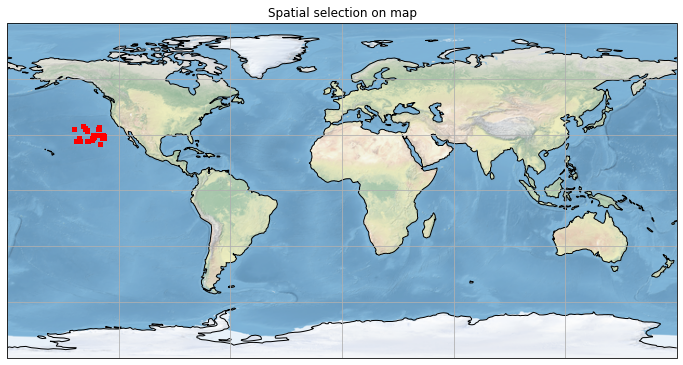

In [7]:
map_viz = plot_pmesh()

## Generate property plots
To visualize relationships between profile measurements, we can plot features in a property plot. Each line is specified by `z_col` which can be any of the following: 
- 'profile_id'
- 'date'

In [8]:
xy = [('Pressure', 'pres'),('Temperature', 'temp'),('Salinity', 'psal')]
z = [('Profile ID', 'profile_id'),('Date', 'date'),('Date(month)', 'date_month')]
x_drop = widgets.Dropdown(options=xy, val='Pressure', description='X-variable', disabled=False)
y_drop = widgets.Dropdown(options=xy, val='Temperature', description='Y-variable', disabled=False)
z_drop = widgets.Dropdown(options=z, val='Profile ID', description='Z-variable', disabled=False)
widgets.VBox([x_drop, y_drop, z_drop])

unit_dict = {'pres':'Pressure [dbar]', 'temp': 'Temperature [Celsius]', 'psal':'Salinity [psu]'}

def property_plot_selection(x_col, y_col, z_col):
    fig, ax = plt.subplots()

    for key, group in selectionDf.groupby([z_col]):
        ax = group.plot(ax=ax, kind='line', x=x_col, y=y_col, label=key, figsize=(15,10))
        
    if y_col == 'pres':
        ax.set_ylim(ax.get_ylim()[::-1])
    
    ax.set_title(unit_dict[x_col].split(' ')[0]+ ' vs. ' +unit_dict[y_col].split(' ')[0])
    ax.set_xlabel(unit_dict[x_col])
    ax.set_ylabel(unit_dict[y_col])
    legendPos = ax.get_position()
    ax.set_position([legendPos.x0, legendPos.y0, legendPos.width*0.6, legendPos.height])
    ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
    plt.show()

interactive(children=(Dropdown(description='X-variable', options=(('Pressure', 'pres'), ('Temperature', 'temp'…

<function __main__.property_plot_selection(x_col, y_col, z_col)>

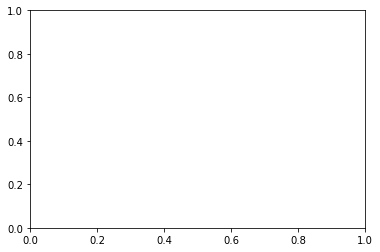

In [9]:
widgets.interact(property_plot_selection, x_col=x_drop, y_col=y_drop, z_col=z_drop)



## The 10 rules
These recommendations are based on [6]

1. Tell a story for an audience: interleave explanatory text with code and results to create a computational narrative.

2. Document the process, not just the results: so that others, and yourself later, will understand your reasoning and choices.

3. Use cell divisions to make steps clear: have eaach cell perform one meaningful and documented step, avoid long cells.

4. Modularize code: use and document functions for repeated operations to make the code more readable and save space.

5. Record dependencies: use pip or Conda package manager, with environment.yml (Conda) or requirements.txt (pip). Please indicate package versions explicitly. Ideally, include a listing of dependencies at the bottom of the notebook. Make sure you test your notebook in an environment created from these dependencies, so that you don't add undocumened dependencies.

6. Use version control: https://github.com/jupyter/nbdime is a diffing tool specifically designed for notebooks; you may find it useful.

7. Build a pipeline: place key variable declarations at the top. Test with different parameters, clean up, and run all cells to prepare for potential non-interactive execution.

8. Share and explain your data: if the original data are too big, inlude a sample. Make sure that the data is accessible. Include data description, and any processing done beforehand. Ideally, point to datasets that have been permanently managed and identified by DOIs.

9. Design your notebooks to be read, run, and explored:  
    9.1. Read: store it in a public code repository with a clear README file and a liberal open source license. Generate HTML/PDF versions of the final notebook.  
    9.2. Run: use Binder to run it in the cloud, and/or create a Docker image.  
    9.3. Explore: use interactive widgets (e.g., ipywidgets, or panel) 
    
10. Advocate for open research: ask your colleagues or friends to try to run your notebooks.


__Additional recommendations, beyond the 10 rules:__
1. Do not include shell commands in cells (unless the notebook will be distributed in Docker container.)
2. Keep cell output if other researchers will use the included data, or clear cell output if they will use their own data.
3. Develop your code in a clean virtual environment, to avoid dependency conflicts and streamline packaging.

To create a virtual environment, use
```
conda create -n <enviroment_name> python=3 jupyter -y
```
or
```
python3 -m venv /path/to/new/virtual/environment
```
and then activate it. See more about creating virtual environments in [9], [10].

For additional useful guides see [1], [2], [3], [4]


# References
List relevant references:
